<a href="https://colab.research.google.com/github/bjornoshake/Lyrics-Generator/blob/main/KDD_Attaque_Reseaux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook KDD Attaques Réseaux

#1.Commençons par télécharger nos données et les traiter

##A executer si on veut tout le dataset

In [ ]:
! wget -N http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
! gunzip -f kddcup.data.gz
! wget -N http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names #Pour récup le nom des colonnes
#On traite ce fichier pour en extraire les noms des colonnes dans un format utilisable et y ajouter la colonne "label"
! tail -n +2 kddcup.names > kddcup.names.no_headers
#On fusionne les noms des colonnes avec le dataset dans un même fichier
! features=""; while read line; do features=$features,$(echo "$line" | cut -d':' -f 1); done< kddcup.names.no_headers; echo "${features:1},label">features
! cat features kddcup.data > dataset && head dataset
#Et la lib de visualisation
! wget -N https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py

--2020-06-09 12:51:27--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18115902 (17M) [application/x-gzip]
Saving to: ‘kddcup.data.gz’

kddcup.data.gz      100%[===================>]  17.28M  30.0MB/s    in 0.6s    

2020-06-09 12:51:28 (30.0 MB/s) - ‘kddcup.data.gz’ saved [18115902/18115902]

--2020-06-09 12:51:35--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1307 (1.3K)
Saving to: ‘kddcup.names’

kddcup.names        100%[===================>]   1.28K  --.-KB/s    in 0s      

2020-06-09 12:51:36 (238 MB/s) - ‘kddcup.names’ saved [1307/1307]

duration,protocol_type,service,flag,src

##A executer si on ne veut que 10% du dataset

In [ ]:
! wget -N http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
! gunzip -f kddcup.data_10_percent.gz
! wget -N http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names #Pour récup le nom des colonnes
#On traite ce fichier pour en extraire les noms des colonnes dans un format utilisable et y ajouter la colonne "label"
! tail -n +2 kddcup.names > kddcup.names.no_headers
#On fusionne les noms des colonnes avec le dataset dans un même fichier
! features=""; while read line; do features=$features,$(echo "$line" | cut -d':' -f 1); done< kddcup.names.no_headers; echo "${features:1},label">features
! cat features kddcup.data_10_percent > datasetp && head datasetp
#Et la lib de visualisation
! wget -N https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py

--2020-06-09 12:51:45--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent.gz’

kddcup.data_10_perc 100%[===================>]   2.04M  5.55MB/s    in 0.4s    

2020-06-09 12:51:45 (5.55 MB/s) - ‘kddcup.data_10_percent.gz’ saved [2144903/2144903]

--2020-06-09 12:51:48--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘kddcup.names’ not modified on server. Omitting download.

duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromise

#2.Importons les libs importantes

In [ ]:
import pandas as pd #Pour l'affichage des tableaux
import numpy as np
import math
import matplotlib.pyplot as plt #Pour les graphiques
import os
import sys
import visualization
from visualization import plot_conf_mat, plot_feature_importances


from pandas.plotting import scatter_matrix

! pip install category_encoders
import category_encoders as ce


from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
# May not work in the old versions of scikit-learn
from sklearn.metrics import plot_confusion_matrix  

from collections import Counter

from imblearn.over_sampling import SMOTE


!pip install ipython-autotime # To show time at each cell
                              # Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
%load_ext autotime

# The following is to be able to mount Google Drive
from google.colab import drive

import pickle # To save the model
from os.path import isfile


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 81kB 2.7MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=91abbc9d51de432e9a9e4113d8c884944924d4e5dcf59f9baa874142620a89a2
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


#3.Et c'est parti

In [ ]:
df = pd.read_csv('dataset',sep=',')

time: 16.1 s


In [ ]:
dfp = pd.read_csv('datasetp',sep=',') #Dataframe du dataset à 10%

time: 1.63 s


In [ ]:
df.head(n=25)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.
5,0,tcp,http,SF,238,1282,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,5,1.0,0.0,0.20,0.0,0.0,0.0,0.0,0.0,normal.
6,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6,6,1.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,normal.
7,0,tcp,http,SF,234,1364,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7,7,1.0,0.0,0.14,0.0,0.0,0.0,0.0,0.0,normal.
8,0,tcp,http,SF,239,1295,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,8,1.0,0.0,0.12,0.0,0.0,0.0,0.0,0.0,normal.
9,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.


time: 79.4 ms


In [ ]:
df.shape

(4898431, 42)

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     int64  
 1   protocol_type                object 
 2   service                      object 
 3   flag                         object 
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells                   int64  
 18  num_access_files             int64  
 19  

In [ ]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4898431.0,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06
mean,4.834243e+01,1.834621e+03,1.093623e+03,5.716116e-06,6.487792e-04,7.961733e-06,1.243766e-02,3.205108e-05,1.435290e-01,8.088304e-03,6.818510e-05,3.674646e-05,1.293496e-02,1.188748e-03,7.430951e-05,1.021143e-03,0.0,4.082940e-07,8.351654e-04,3.349734e+02,2.952671e+02,1.779703e-01,1.780370e-01,5.766509e-02,5.773010e-02,7.898842e-01,2.117961e-02,2.826080e-02,2.329811e+02,1.892142e+02,7.537132e-01,3.071111e-02,6.050520e-01,6.464107e-03,1.780911e-01,1.778859e-01,5.792780e-02,5.765941e-02
std,7.233298e+02,9.414311e+05,6.450123e+05,2.390833e-03,4.285434e-02,7.215084e-03,4.689782e-01,7.299408e-03,3.506116e-01,3.856481e+00,8.257146e-03,8.082432e-03,3.938075e+00,1.241857e-01,8.737590e-03,3.551048e-02,0.0,6.389788e-04,2.888716e-02,2.119908e+02,2.459927e+02,3.818756e-01,3.822541e-01,2.322529e-01,2.326604e-01,3.892958e-01,8.271458e-02,1.405596e-01,6.402094e+01,1.059128e+02,4.111860e-01,1.085432e-01,4.809877e-01,4.125978e-02,3.818382e-01,3.821774e-01,2.309428e-01,2.309777e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.210000e+02,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,4.900000e+01,4.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.100000e+02,5.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,2.550000e+02,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.032000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.110000e+02,5.110000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,2.550000e+02,1.000000e+00,4.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.

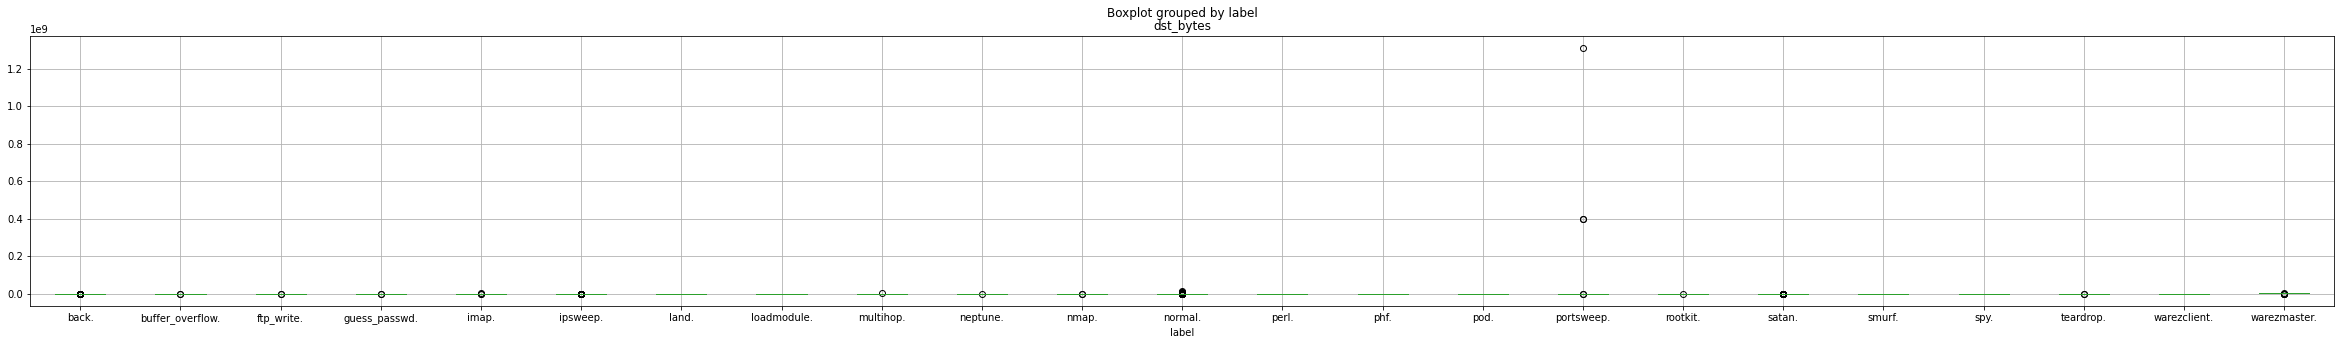

In [ ]:
df.boxplot(column=["dst_bytes"], by="label", figsize=(40,5))

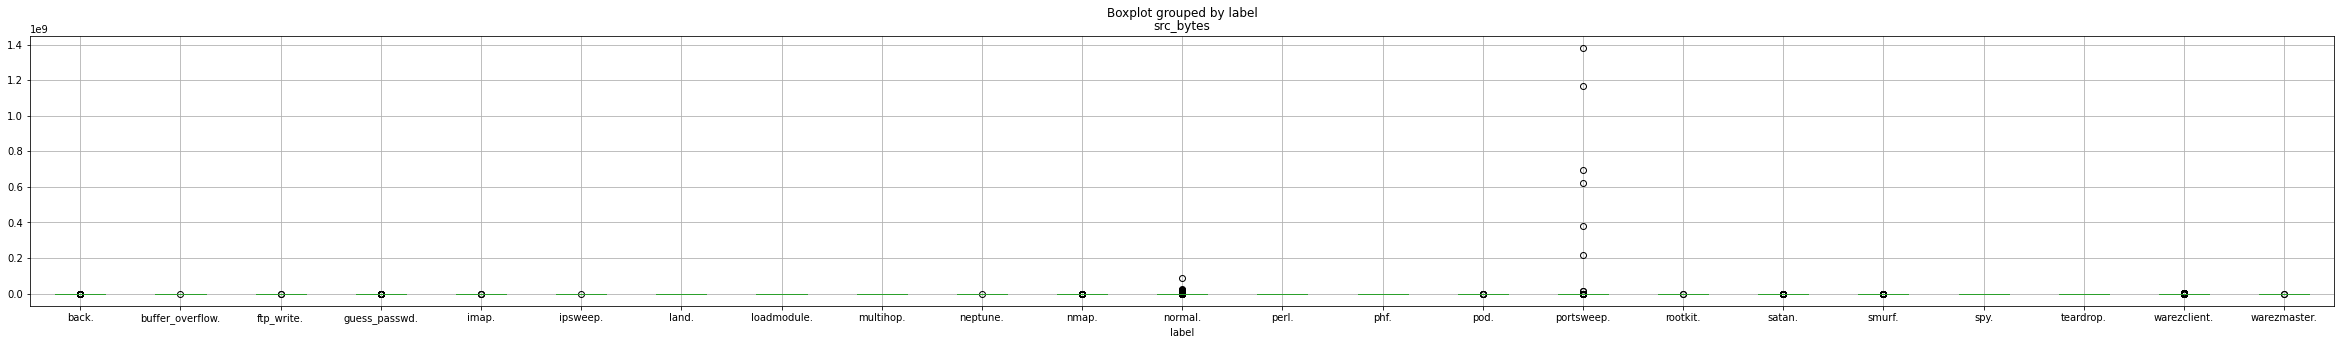

In [ ]:
df.boxplot(column=["src_bytes"], by="label", figsize=(40,5))

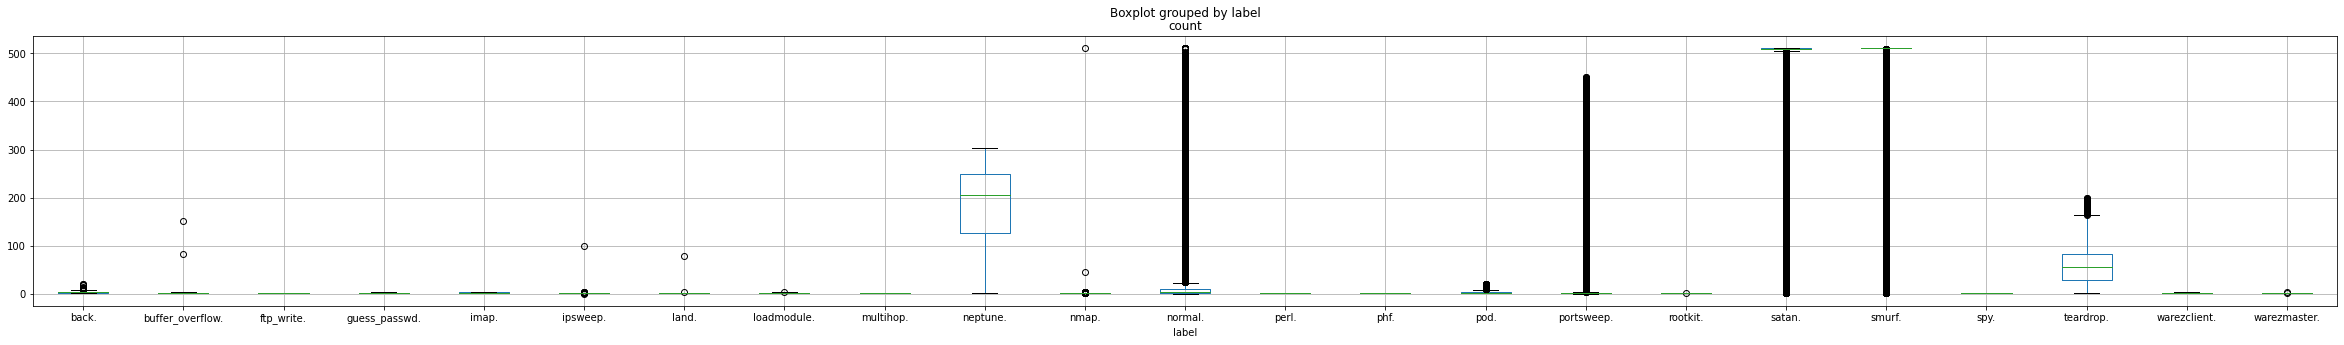

In [ ]:
df.boxplot(column=["count"], by="label", figsize=(40,5))

##Et c'est parti pour la scatter matrix mais j'y crois 0

In [ ]:
features_to_plot = ['duration','src_bytes','dst_bytes','urgent']
sm = scatter_matrix(df[features_to_plot],figsize=(4,4))

Error in callback <function flush_figures at 0x7f443a023620> (for post_execute):


KeyboardInterrupt: ignored

# 4. Un peu d'analyse statistique

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f441bd2e390>,
      dtype=object)

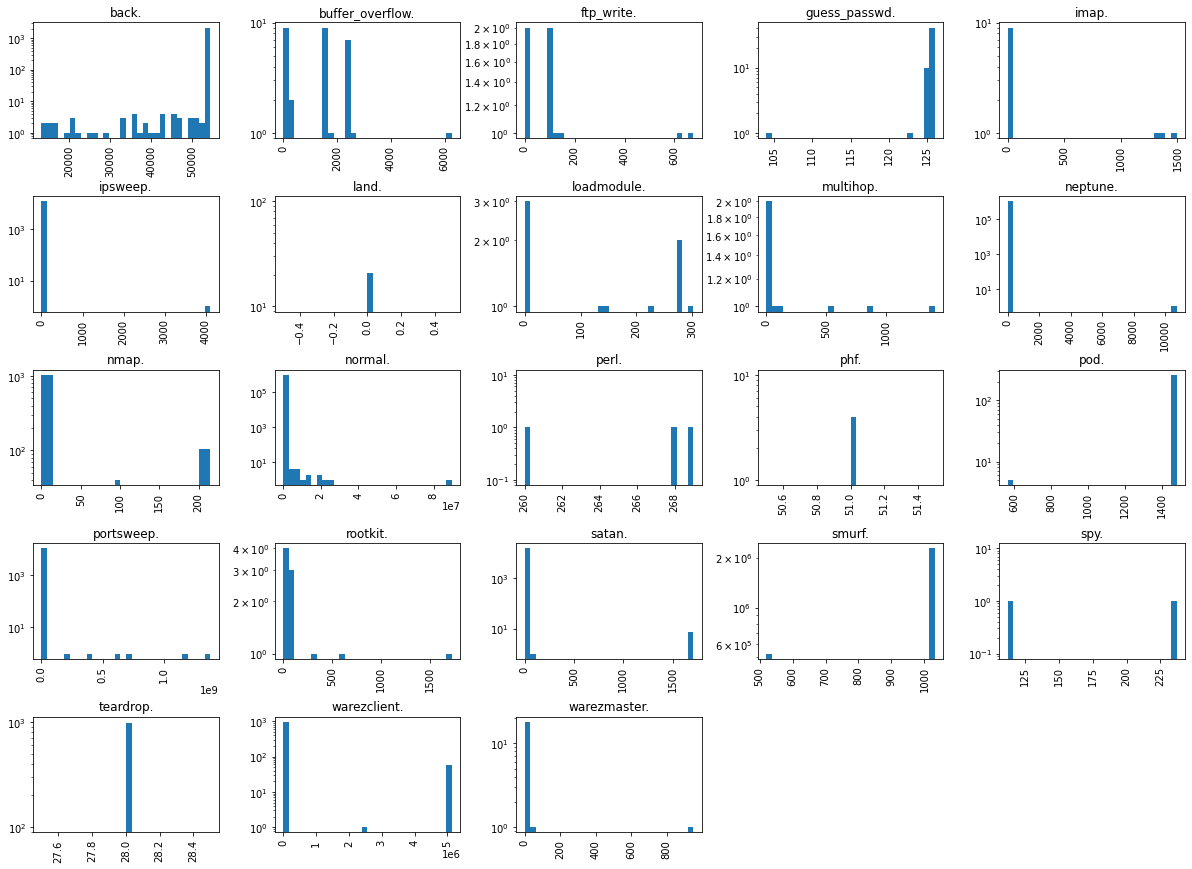

In [ ]:
df[['src_bytes', "label"]].hist(bins=30,figsize=(20,15),log=True,by="label")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f441a5b0be0>,
      dtype=object)

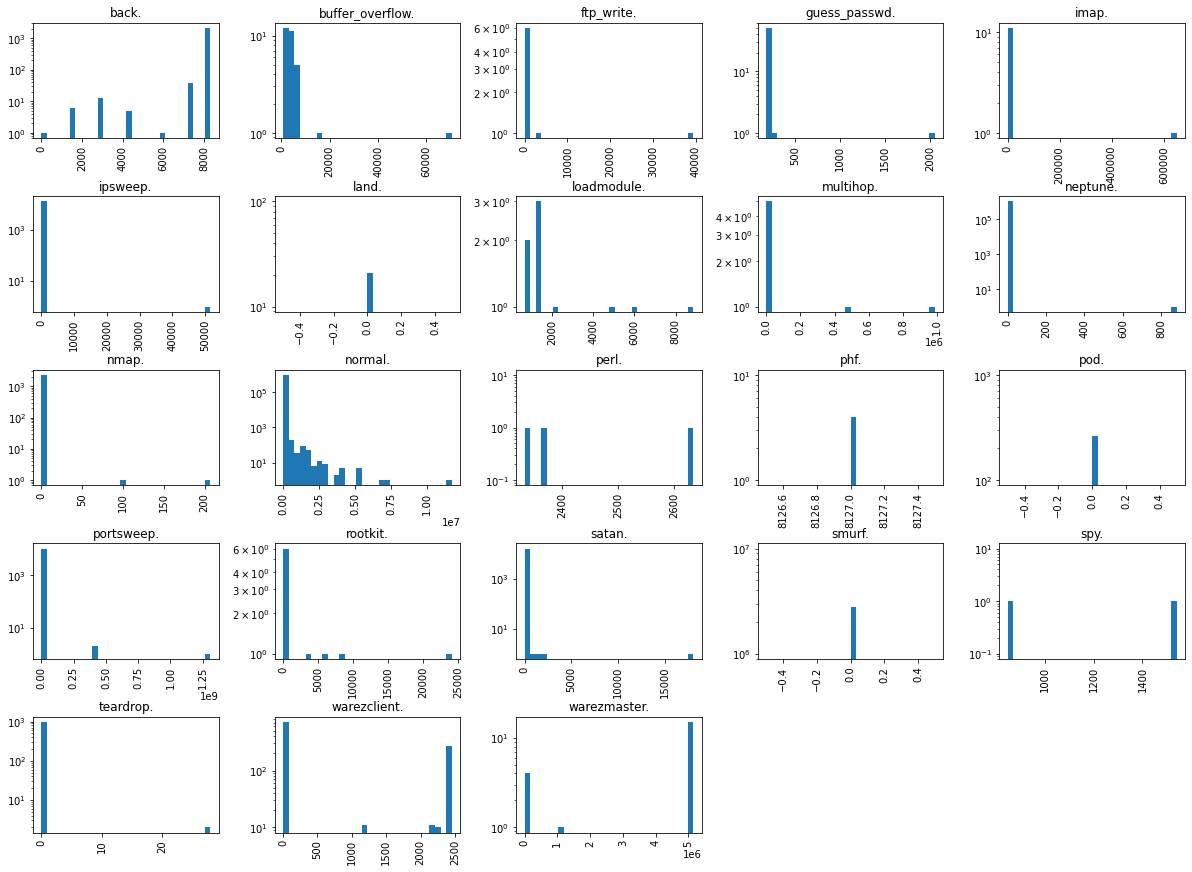

In [ ]:
df[['dst_bytes', "label"]].hist(bins=30,figsize=(20,15),log=True,by="label")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f44184aed68>,
      dtype=object)

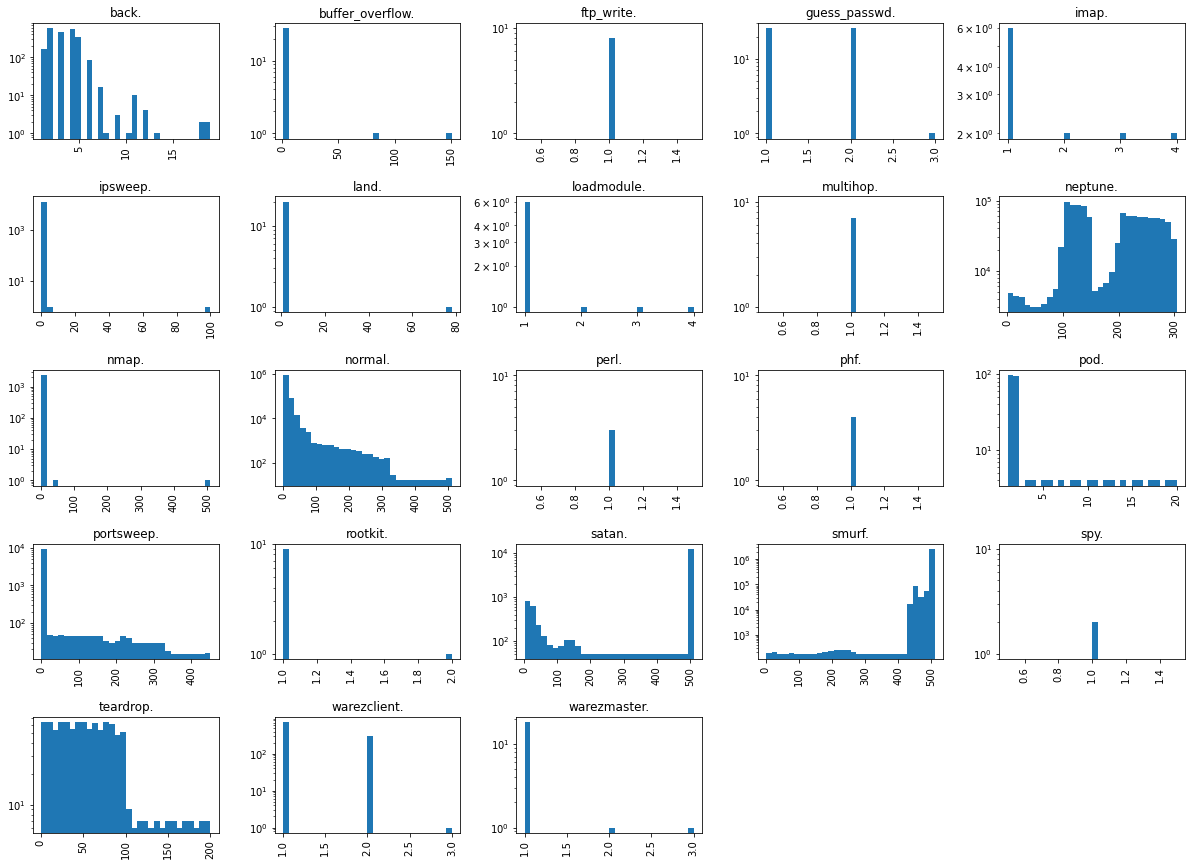

In [ ]:
df[['count', "label"]].hist(bins=30,figsize=(20,15),log=True,by="label")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f441608c5c0>,
      dtype=object)

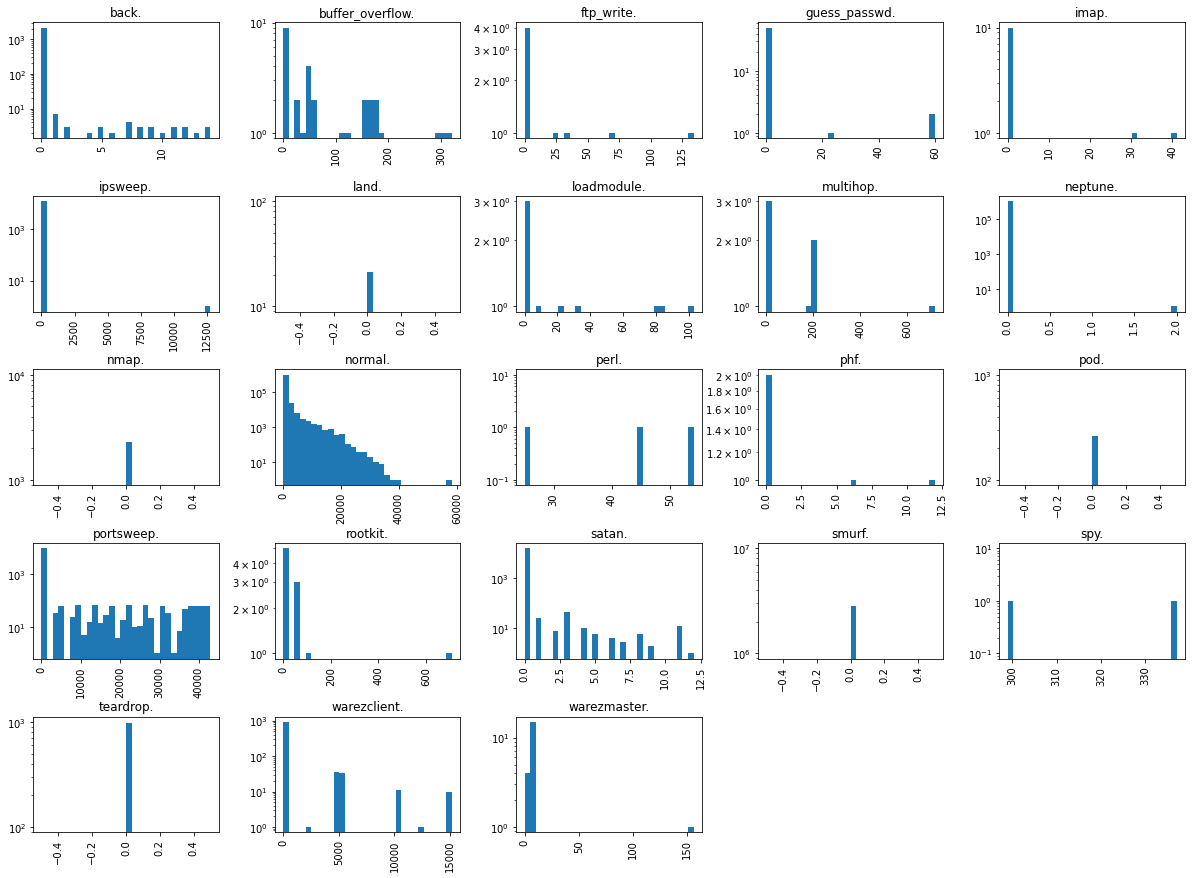

In [ ]:
df[['duration', "label"]].hist(bins=30,figsize=(20,15),log=True,by="label")

#5. On se prépare pour les études de correlation


## On passe un coup de OneHot Encoding sur certaines features

In [ ]:
encoder = ce.OneHotEncoder(cols=['service'], use_cat_names=True)
df_encoded = encoder.fit_transform(df)

## On essaye une scatter matrix

In [ ]:
sm = scatter_matrix(df[["duration", "src_bytes", "dst_bytes", "count", "label"]], figsize=(10,10))
visualization.rotate_labels(sm)
plt.show()

## On plot la correlation

In [ ]:
visualization.plot_corr(df, width=15, height=15, 
                        print_value=False)

#6. Tentons les forêts 

##On commence par monter un drive google

In [ ]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'tsp/' #Lien pour le drive d'Arthur, peut être vaut mieux le changer si vous n'avez pas de fichier 'tsp'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
time: 28.6 s


##On partitionne le dataset en train et test

###Pour le dataset partiel

In [ ]:
#Il semblerait que notre dataset ne soit pas compatible avec la fonction de base du SMOTE à cause de la classe spy ==> on l'enlève
dfp = dfp[dfp.label != 'spy.']
dfp[dfp.flag == 'spy.']
#Et on remplace les labels de string en integer pour pouvoir utiliser plot_conf_mat()
label_array = ['smurf.','neptune.','normal.', 'back.','satan.','ipsweep.','portsweep.', 'warezclient.', 'teardrop.','pod.', 'nmap.', 'guess_passwd.', 'buffer_overflow.', 'warezmaster.', 'land.', 'ftp_write.', 'rootkit.', 'imap.', 'multihop.', 'loadmodule.', 'phf.', 'perl.']
dictionnary = { label : label_array.index(label) for label in label_array }

dfp = dfp.replace({'label' : dictionnary})

#OneHot encoding sur la dfp
encoder = ce.OneHotEncoder(cols=['service'], use_cat_names=True)
dfp_encoded = encoder.fit_transform(dfp)
encoder = ce.OneHotEncoder(cols=['protocol_type'], use_cat_names=True)
dfp_encoded = encoder.fit_transform(dfp_encoded)
encoder = ce.OneHotEncoder(cols=['flag'], use_cat_names=True)
dfp_encoded = encoder.fit_transform(dfp_encoded)
dfp_encoded.head(n=10)

X = dfp_encoded.drop(labels='label', axis=1)
y = dfp_encoded['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, 
                                        shuffle=True, random_state=4)

time: 7.74 s


In [ ]:
X = dfp_encoded.drop(labels='label', axis=1)
y = dfp_encoded['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, 
                                        shuffle=True, random_state=5)

time: 539 ms


###Pour le dataset total

In [ ]:
#On remplace les labels de string en integer pour pouvoir utiliser plot_conf_mat()
label_array = ['smurf.','neptune.','normal.', 'back.','satan.','ipsweep.','portsweep.', 'warezclient.', 'teardrop.','pod.', 'nmap.', 'guess_passwd.', 'buffer_overflow.', 'warezmaster.', 'land.', 'ftp_write.', 'rootkit.', 'imap.', 'multihop.', 'loadmodule.', 'phf.', 'perl.', 'spy.']
dictionnary = { label : label_array.index(label) for label in label_array }

df = df.replace({'label' : dictionnary})

#OneHot encoding sur la df
encoder = ce.OneHotEncoder(cols=['service'], use_cat_names=True)
df_encoded = encoder.fit_transform(df)
encoder = ce.OneHotEncoder(cols=['protocol_type'], use_cat_names=True)
df_encoded = encoder.fit_transform(df_encoded)
encoder = ce.OneHotEncoder(cols=['flag'], use_cat_names=True)
df_encoded = encoder.fit_transform(df_encoded)
df_encoded.head(n=10)


#On va se servir du set 10% comme de base d'entraînement et le set complet comme total

#X_train = dfp_encoded.drop(labels='label', axis=1)
#y_train = dfp_encoded['label']
#X_test = df_encoded.drop(labels='label', axis=1)
#y_test = df_encoded['label']


NameError: ignored

time: 127 ms


In [ ]:
X = df_encoded.drop(labels='label', axis=1)
y = df_encoded['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, 
                                        shuffle=True, random_state=4)

time: 13 s


In [ ]:
df

##Puis on check pour les class imbalance

In [ ]:
print( "Samples per class before SMOTE: ", Counter(y_train) )

smote = SMOTE(k_neighbors=2)
X_train, y_train = smote.fit_sample(X_train, y_train)

print( "Samples per class after SMOTE: ", Counter(y_train) )

Samples per class before SMOTE:  Counter({0: 196597, 1: 74882, 2: 68156, 3: 1574, 4: 1123, 5: 872, 6: 716, 7: 716, 8: 695, 9: 201, 10: 159, 11: 41, 12: 22, 14: 16, 13: 12, 16: 7, 15: 6, 19: 6, 18: 4, 17: 3, 20: 3, 21: 2})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

ValueError: ignored

time: 1min 16s


##Et c'est parti pour les forêts

In [ ]:
model = RandomForestClassifier(n_estimators=100, 
                      criterion='gini', 
                      max_leaf_nodes=16, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'auto' # auto means=sqrt(n_features)
                      )

model.fit(X_train, y_train)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

time: 4min 22s


In [ ]:
y_pred = model.predict(X_test)

class_names = np.array(['smurf.','neptune.','normal.', 'back.','satan.','ipsweep.','portsweep.', 'warezclient.', 'teardrop.','pod.', 'nmap.', 'guess_passwd.', 'buffer_overflow.', 'warezmaster.', 'land.', 'ftp_write.', 'rootkit.', 'imap.', 'multihop.', 'loadmodule.', 'phf.', 'perl.'])
#plot_confusion_matrix(model, X_test, y_test, normalize='true')


time: 3.46 s


Normalized confusion matrix
[[9.99762329e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.37670826e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.89853719e-01 0.00000000e+00 0.00000000e+00
  3.20572674e-03 0.00000000e+00 6.50482415e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.35729847e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.36602691e-04 2.73205382e-04 7.07226282e-01 2.35639642e-03
  1.40017758e-03 8.94747627e-03 5.45044737e-02 8.51034765e-02
  8.01174783e-02 4.06393006e-03 5.12260092e-04 4.43958746e-04
  3.07356055e-04 1.77583498e-03 4.71279284e-03 8.19616146e-04
  4.14589167e-02 1.02452018e-04 0.0000

/content/visualization.py:123: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


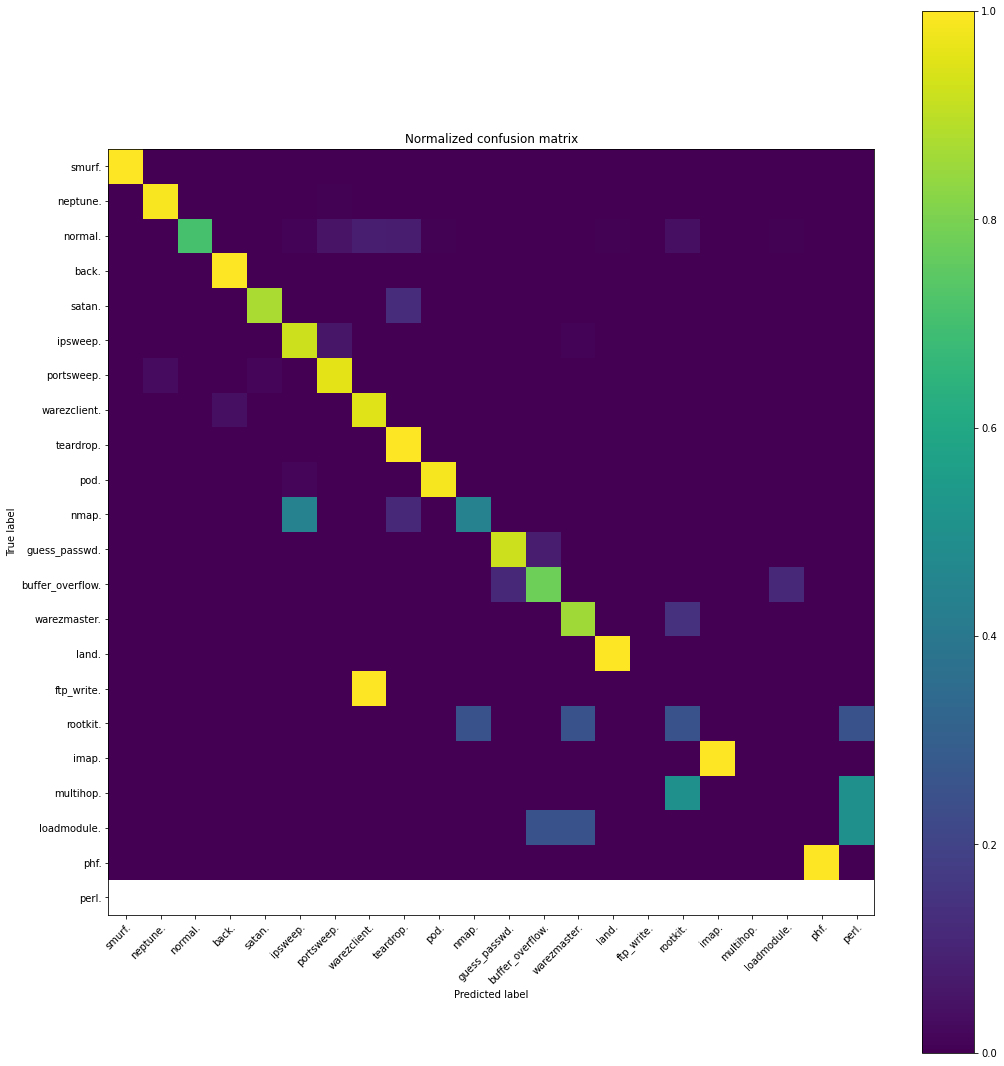

time: 754 ms


In [ ]:
plot_conf_mat(y_test, y_pred, class_names, text=False, width=15, height=15)

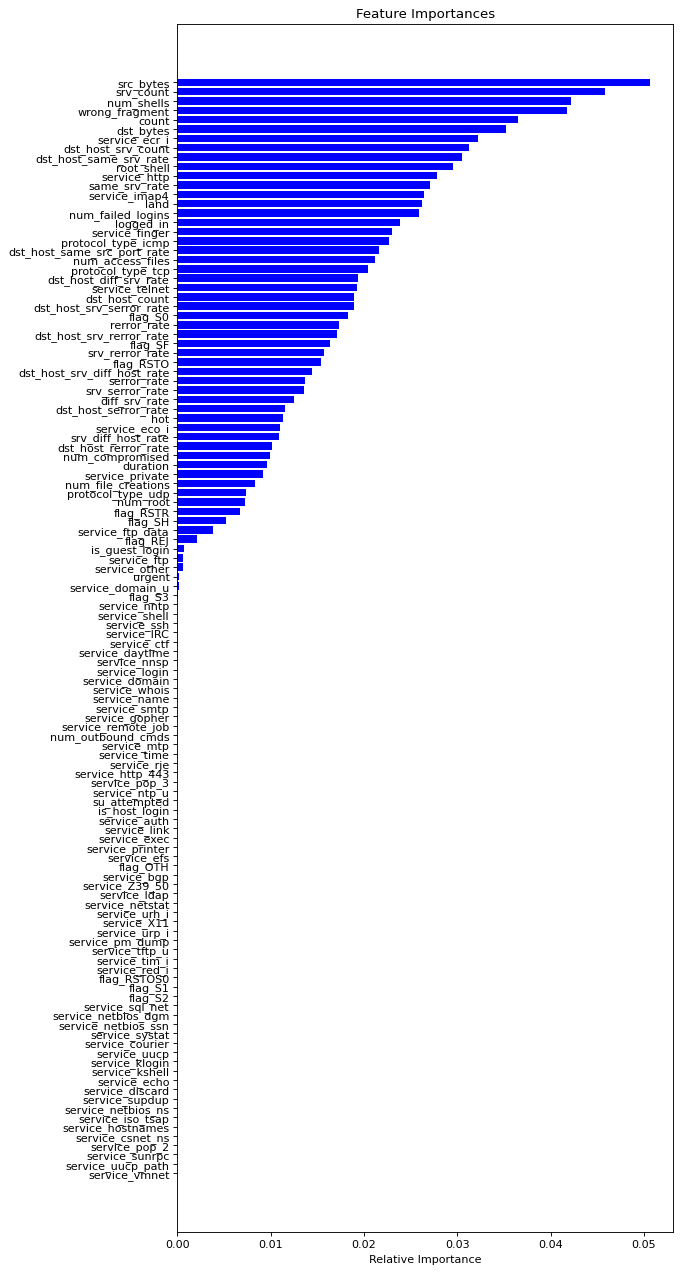

Index(['duration', 'protocol_type_tcp', 'protocol_type_udp',
       'protocol_type_icmp', 'service_http', 'service_smtp', 'service_finger',
       'service_domain_u', 'service_auth', 'service_telnet',
       ...
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object', length=118)

time: 1.39 s


In [ ]:

plt.figure(num=None, figsize=(8, 20), dpi=80, facecolor='w', edgecolor='k') #pour rendre le graph plus grand

feature_names = X_test.columns
plot_feature_importances(model.feature_importances_, feature_names)
feature_names



##On va faire du finetuning sur les hyperparam

In [ ]:
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_features':[1,2,3,4,5],

    # Number of allowed leafs
    'max_leaf_nodes':[16, 32, 64, 128, 256, 512, 1024, 2048],

    # A node will be split if this split induces a decrease of the 
    # impurity greater than or equal to this value.
    'min_impurity_decrease' : [0, 0.001, 0.01, 0.1, 0.2],
            
    'max_depth':[1,10,100,1000,10000,100000],

    # A node can be a leaf only if it contains at least the following fraction
    # of samples
    'min_weight_fraction_leaf' : [0.1, 0.01, 0.001, 0]
    
}

time: 4.13 ms


In [ ]:
# Note that we use 1 CPU per classifier, since we are training different 
# classifiers
forest = RandomForestClassifier(n_estimators=100, random_state = 4, n_jobs=1,)


search = RandomizedSearchCV(
                            scoring = 'accuracy', # See other possible metrics in
                                                # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                            
                            estimator=forest, 
                            param_distributions=param_grid,
                            n_iter=50, # We just test 50 configurations
                            verbose=2,random_state=42, 
                            n_jobs=-1, # Triain forests in parallel using 
                                      # all CPUs
                            cv=5 # 5-fold validation                      
                          )

search.fit(X_test, y_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


TerminatedWorkerError: ignored

time: 17.2 s


{'min_weight_fraction_leaf': 0.001, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 32, 'max_features': 5, 'max_depth': 10000, 'criterion': 'entropy'}
Normalized confusion matrix
[[9.99988116e-01 0.00000000e+00 1.18835413e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 9.99875506e-01 1.24494242e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.18564306e-03 6.83013455e-05 9.97746056e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000

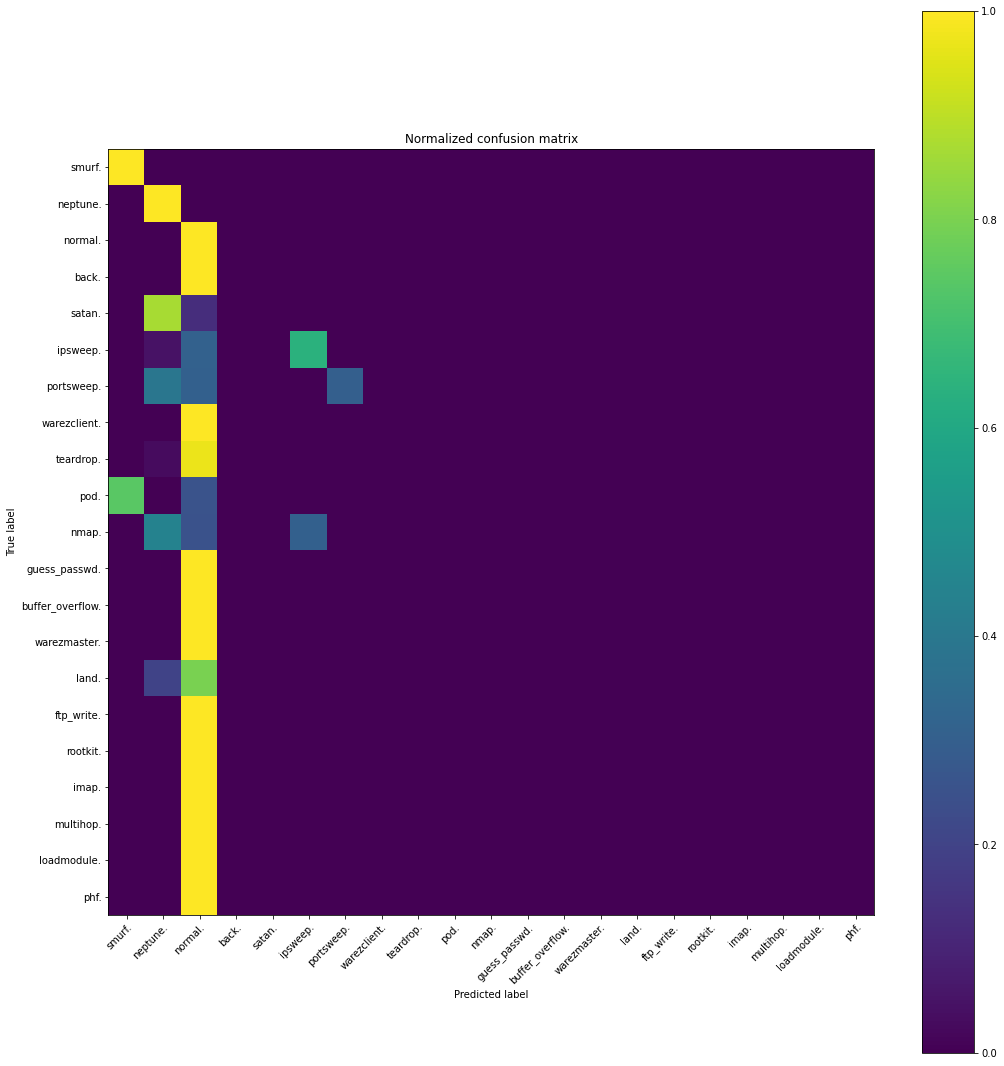

time: 2.44 s


In [ ]:


print(search.best_params_)

model = search.best_estimator_
y_pred = model.predict(X_test)

plot_conf_mat(y_test, y_pred, class_names, text=False, width=15, height=15)



In [ ]:
def search_or_load(model_filename, search):
  if(isfile(model_filename) ):
    model = pickle.load(open(model_filename, 'rb'))

  else:
    search.fit(X_train, y_train)
    print(search.best_params_)
    model = search.best_estimator_
    pickle.dump(model, open(model_filename, 'wb'))

  return model

time: 2.88 ms


In [ ]:
filename = my_path+'forest-1.pkl'
model = search_or_load(filename, search)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.4min finished


{'min_weight_fraction_leaf': 0.001, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 32, 'max_features': 5, 'max_depth': 10000, 'criterion': 'entropy'}
time: 3min 28s


In [ ]:
forest = RandomForestClassifier(n_estimators=100, random_state = 4, n_jobs=1,)


search = RandomizedSearchCV(
                            scoring = 'accuracy', # See other possible metrics in
                                                # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                            
                            estimator=forest, 
                            param_distributions=param_grid,
                            n_iter=200,
                            verbose=2,random_state=42, 
                            n_jobs=-1, # Triain forests in parallel using 
                                      # all CPUs
                            cv=5 # 5-fold validation                      
                          )


filename = my_path + 'forest-2-meilleur.pkl'
model = search_or_load(filename, search)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


TerminatedWorkerError: ignored

time: 47.8 s


Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.99969058e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.09415514e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.43383009e-05 9.99931323e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.43383009e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.0000

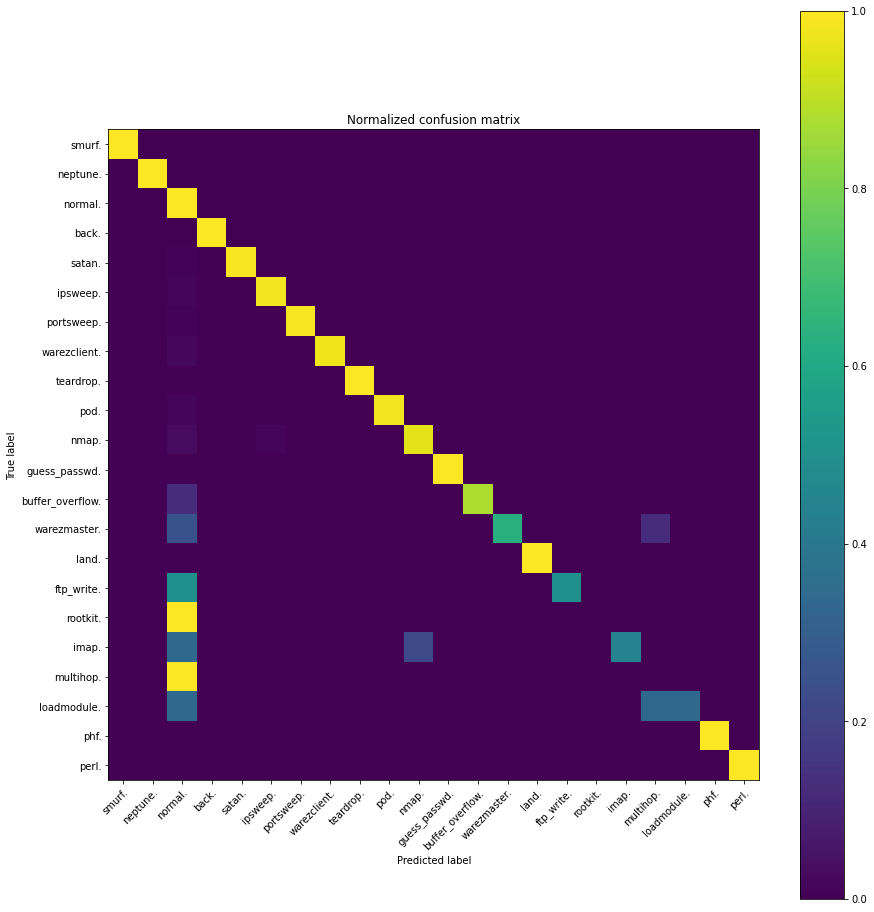

time: 5.75 s


In [ ]:
y_pred = model.predict(X_test)
class_names = np.array(['smurf.','neptune.','normal.', 'back.','satan.','ipsweep.','portsweep.', 'warezclient.', 'teardrop.','pod.', 'nmap.', 'guess_passwd.', 'buffer_overflow.', 'warezmaster.', 'land.', 'ftp_write.', 'rootkit.', 'imap.', 'multihop.', 'loadmodule.', 'phf.', 'perl.'])

plot_conf_mat(y_test, y_pred, class_names, text=False, width=13, height=13)

##Tentons en séparant en type d'attaques

In [ ]:
label_array = ['smurf.','neptune.','normal.', 'back.','satan.','ipsweep.','portsweep.', 'warezclient.', 'teardrop.','pod.', 'nmap.', 'guess_passwd.', 'buffer_overflow.', 'warezmaster.', 'land.', 'ftp_write.', 'rootkit.', 'imap.', 'multihop.', 'loadmodule.', 'phf.', 'perl.', 'spy.']
dos = ['back.','land.','neptune.','pod.','smurf.','teardrop.']
u2r = ['buffer_overflow.','loadmodule.','perl.','rootkit.']
r2l = ['ftp_write.','guess_passwd.','imap.','multihop.','phf.','spy.','warezclient.','warezmaster.']
probe = ['ipsweep.','nmap.','portsweep.','satan.']
dictionnary_lite = {'normal.':0}
for label in label_array:
  if ((label != 'normal.') and (label not in dictionnary_lite)):
    if label in dos:
      dictionnary_lite[label]=1
    elif label in u2r:
      dictionnary_lite[label]=2
    elif label in r2l:
      dictionnary_lite[label]=3
    elif label in probe:
      dictionnary_lite[label]=4
    else:
      print("Error",label)
      break
label_array_lite = ['normal','dos','u2r','r2l','probe']


time: 9.53 ms


In [ ]:
print(dictionnary_lite)

{'normal.': 0, 'smurf.': 1, 'neptune.': 1, 'back.': 1, 'satan.': 4, 'ipsweep.': 4, 'portsweep.': 4, 'warezclient.': 3, 'teardrop.': 1, 'pod.': 1, 'nmap.': 4, 'guess_passwd.': 3, 'buffer_overflow.': 2, 'warezmaster.': 3, 'land.': 1, 'ftp_write.': 3, 'rootkit.': 2, 'imap.': 3, 'multihop.': 3, 'loadmodule.': 2, 'phf.': 3, 'perl.': 2, 'spy.': 3}
time: 800 µs


In [ ]:
dfp_lite = dfp.replace({'label' : dictionnary_lite})

time: 462 ms


In [ ]:
dfp_encoded.shape

(494019, 119)

time: 2.4 ms


In [ ]:
#OneHot encoding sur la dfp_lite
encoder = ce.OneHotEncoder(cols=['service'], use_cat_names=True)
dfp_lite_encoded = encoder.fit_transform(dfp_lite)
encoder = ce.OneHotEncoder(cols=['protocol_type'], use_cat_names=True)
dfp_lite_encoded = encoder.fit_transform(dfp_lite_encoded)
encoder = ce.OneHotEncoder(cols=['flag'], use_cat_names=True)
dfp_lite_encoded = encoder.fit_transform(dfp_lite_encoded)
dfp_lite_encoded.head(n=10)


,duration,protocol_type_tcp,protocol_type_udp,protocol_type_icmp,service_http,service_smtp,service_finger,service_domain_u,service_auth,service_telnet,service_ftp,service_eco_i,service_ntp_u,service_ecr_i,service_other,service_private,service_pop_3,service_ftp_data,service_rje,service_time,service_mtp,service_link,service_remote_job,service_gopher,service_ssh,service_name,service_whois,service_domain,service_login,service_imap4,service_daytime,service_ctf,service_nntp,service_shell,service_IRC,service_nnsp,service_http_443,service_exec,service_printer,service_efs,...,flag_OTH,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,0
1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,0
3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,0
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0
5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,59,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0
6,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,212,1940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,0
7,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,159,4087,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,0
8,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,210,151,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,0
9,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,212,786,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,0


time: 9.37 s


In [ ]:
X = dfp_lite_encoded.drop(labels='label', axis=1)
y = dfp_lite_encoded['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, 
                                        shuffle=True, random_state=4)

time: 674 ms


In [ ]:
dfp_lite_encoded.label.unique()

array([0, 2, 1, 3, 4])

time: 4.39 ms


In [ ]:
print( "Samples per class before SMOTE: ", Counter(y_train) )

smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

print( "Samples per class after SMOTE: ", Counter(y_train) )

Samples per class before SMOTE:  Counter({1: 274233, 0: 67868, 4: 2898, 3: 780, 2: 35})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Samples per class after SMOTE:  Counter({1: 274233, 0: 274233, 4: 274233, 3: 274233, 2: 274233})
time: 30.5 s


In [ ]:
dfp_lite_encoded.shape

(494021, 119)

time: 2.41 ms


In [ ]:
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_features':[1,2,3,4,5],

    # Number of allowed leafs
    'max_leaf_nodes':[16, 32, 64, 128, 256, 512, 1024, 2048],

    # A node will be split if this split induces a decrease of the 
    # impurity greater than or equal to this value.
    'min_impurity_decrease' : [0, 0.001, 0.01, 0.1, 0.2],
            
    'max_depth':[1,10,100,1000,10000,100000],

    # A node can be a leaf only if it contains at least the following fraction
    # of samples
    'min_weight_fraction_leaf' : [0.1, 0.01, 0.001, 0]
    
}
def search_or_load(model_filename, search):
  if(isfile(model_filename) ):
    model = pickle.load(open(model_filename, 'rb'))

  else:
    search.fit(X_train, y_train)
    print(search.best_params_)
    model = search.best_estimator_
    pickle.dump(model, open(model_filename, 'wb'))

  return model

forest = RandomForestClassifier(n_estimators=200, random_state = 4, n_jobs=1,)


time: 10.3 ms


In [ ]:
search = RandomizedSearchCV(
                            scoring = 'accuracy', # See other possible metrics in
                                                # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                            
                            estimator=forest, 
                            param_distributions=param_grid,
                            n_iter=100,
                            verbose=2,random_state=42, 
                            n_jobs=-1, # Triain forests in parallel using 
                                      # all CPUs
                            cv=5 # 5-fold validation                      
                          )


filename = my_path + 'forest-1-lite.pkl'
model = search_or_load(filename, search)
y_pred = model.predict(X_test)
class_names = np.array(label_array_lite)
plot_conf_mat(y_test, y_pred, class_names, text=False, width=13, height=13)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


TerminatedWorkerError: ignored

time: 15.8 s


##Après le finetuning sur les params, avec le dataset total

In [ ]:
filename = my_path + 'forest-2.pkl'
model = search_or_load(filename, search)

time: 30.6 ms


Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.99969058e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.09415514e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.99965662e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.43383009e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.0000

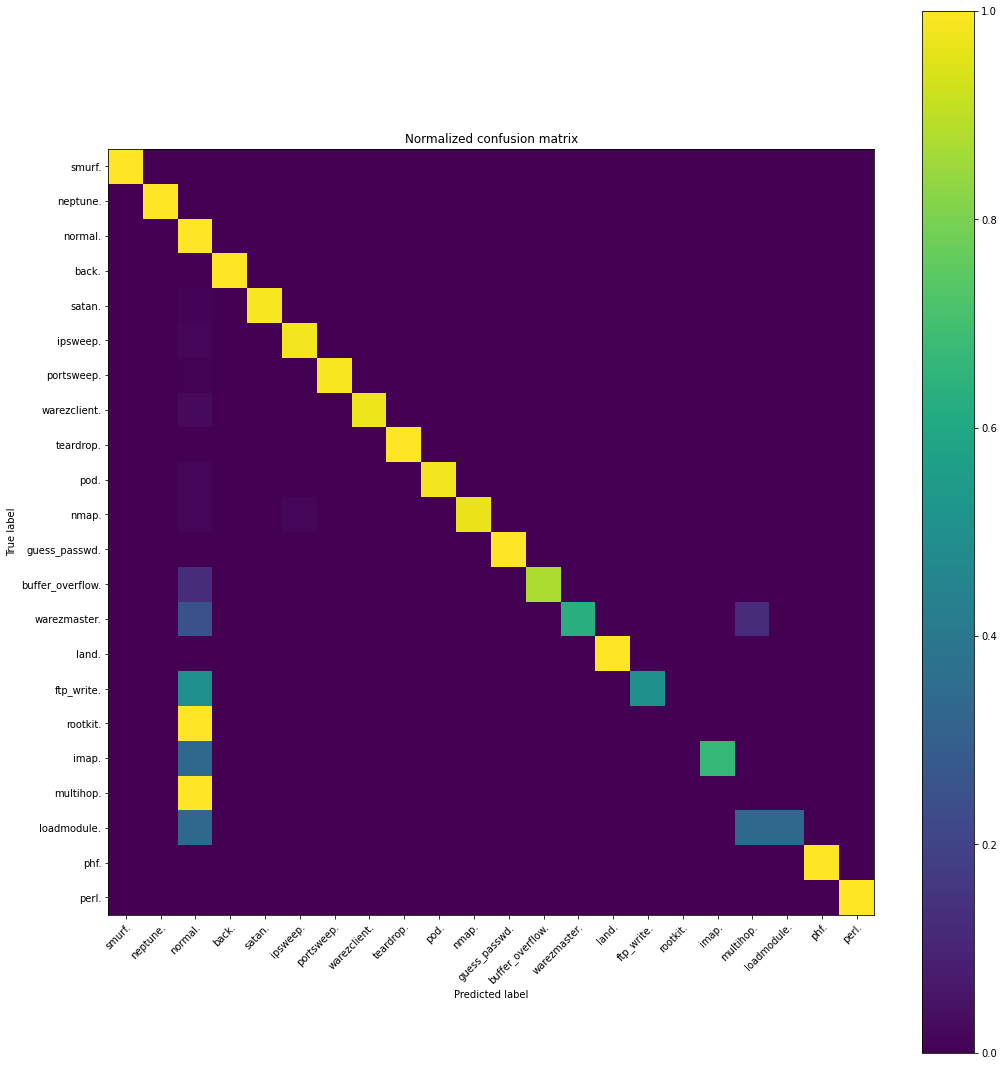

time: 3.62 s


In [ ]:
y_pred = model.predict(X_test)

class_names = np.array(['smurf.','neptune.','normal.', 'back.','satan.','ipsweep.','portsweep.', 'warezclient.', 'teardrop.','pod.', 'nmap.', 'guess_passwd.', 'buffer_overflow.', 'warezmaster.', 'land.', 'ftp_write.', 'rootkit.', 'imap.', 'multihop.', 'loadmodule.', 'phf.', 'perl.', 'spy.'])
plot_conf_mat(y_test, y_pred, class_names, text=False, width=15, height=15)

##Et si on tentait de tout dropper sauf les features importantes ?

In [ ]:
df_cut = df[['label','src_bytes', 'srv_count', 'num_shells', 'wrong_fragment', 'count', 'dst_bytes', 'service', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'root_shell', 'same_srv_rate', 'land', 'num_failed_logins', 'logged_in', 'protocol_type', 'dst_host_same_src_port_rate', 'num_access_files', 'dst_host_diff_srv_rate', 'dst_host_count', 'dst_host_srv_serror_rate', 'flag', 'rerror_rate', 'dst_host_diff_srv_rate', 'srv_rerror_rate', 'dst_host_srv_diff_host_rate', 'serror_rate', 'srv_serror_rate', 'diff_srv_rate', 'dst_host_serror_rate', 'hot','srv_diff_host_rate', 'dst_host_rerror_rate', 'num_compromised', 'duration', 'num_file_creations', 'num_root', 'service', 'is_guest_login', 'urgent']]

time: 690 ms


In [ ]:
label_array = ['smurf.','neptune.','normal.', 'back.','satan.','ipsweep.','portsweep.', 'warezclient.', 'teardrop.','pod.', 'nmap.', 'guess_passwd.', 'buffer_overflow.', 'warezmaster.', 'land.', 'ftp_write.', 'rootkit.', 'imap.', 'multihop.', 'loadmodule.', 'phf.', 'perl.', 'spy.']
dictionnary = { label : label_array.index(label) for label in label_array }

df_cut = df.replace({'label' : dictionnary})

#OneHot encoding sur la df_cut
encoder = ce.OneHotEncoder(cols=['service'], use_cat_names=True)
df_cut_encoded = encoder.fit_transform(df_cut)
encoder = ce.OneHotEncoder(cols=['protocol_type'], use_cat_names=True)
df_cut_encoded = encoder.fit_transform(df_cut_encoded)
encoder = ce.OneHotEncoder(cols=['flag'], use_cat_names=True)
df_cut_encoded = encoder.fit_transform(df_cut_encoded)
df_cut_encoded.head(n=10)



,duration,protocol_type_tcp,protocol_type_udp,protocol_type_icmp,service_http,service_smtp,service_domain_u,service_auth,service_finger,service_telnet,service_eco_i,service_ftp,service_ntp_u,service_ecr_i,service_other,service_urp_i,service_private,service_pop_3,service_ftp_data,service_netstat,service_daytime,service_ssh,service_echo,service_time,service_name,service_whois,service_domain,service_mtp,service_gopher,service_remote_job,service_rje,service_ctf,service_supdup,service_link,service_systat,service_discard,service_X11,service_shell,service_login,service_imap4,...,flag_RSTOS0,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,2
1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,2
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,2
3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,2
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,2
5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,238,1282,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,5,1.0,0.0,0.20,0.0,0.0,0.0,0.0,0.0,2
6,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6,6,1.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,2
7,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,234,1364,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7,7,1.0,0.0,0.14,0.0,0.0,0.0,0.0,0.0,2
8,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,239,1295,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,8,1.0,0.0,0.12,0.0,0.0,0.0,0.0,0.0,2
9,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,2


time: 1min 16s


In [ ]:
df_cut.shape

(4898431, 40)

time: 2 ms


In [ ]:
#SAVE IT
df_cut_encoded.to_csv(my_path+'/df_cut_encoded.csv', index=False)

In [ ]:
#on recup notre super model : 
filename = my_path + 'forest-2.pkl'
model = search_or_load(filename, search)

time: 20.9 ms


In [ ]:
#On le passe sur le dataset total 
X_test = df_cut_encoded.drop(labels='label', axis=1)
y_test = df_cut_encoded['label']
y_pred = model.predict(X_test)

class_names = np.array(['smurf.','neptune.','normal.', 'back.','satan.','ipsweep.','portsweep.', 'warezclient.', 'teardrop.','pod.', 'nmap.', 'guess_passwd.', 'buffer_overflow.', 'warezmaster.', 'land.', 'ftp_write.', 'rootkit.', 'imap.', 'multihop.', 'loadmodule.', 'phf.', 'perl.'])
plot_conf_mat(y_test, y_pred, class_names, text=False, width=15, height=15)

ValueError: ignored

time: 9.97 s


###On va entraîner un nouveau super model sur la dfp_cut pour avoir le même nom de features partout

In [ ]:
dfp_cut = dfp[['label','src_bytes', 'srv_count', 'num_shells', 'wrong_fragment', 'count', 'dst_bytes', 'service', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'root_shell', 'same_srv_rate', 'land', 'num_failed_logins', 'logged_in', 'protocol_type', 'dst_host_same_src_port_rate', 'num_access_files', 'dst_host_diff_srv_rate', 'dst_host_count', 'dst_host_srv_serror_rate', 'flag', 'rerror_rate', 'dst_host_diff_srv_rate', 'srv_rerror_rate', 'dst_host_srv_diff_host_rate', 'serror_rate', 'srv_serror_rate', 'diff_srv_rate', 'dst_host_serror_rate', 'hot','srv_diff_host_rate', 'dst_host_rerror_rate', 'num_compromised', 'duration', 'num_file_creations', 'num_root', 'service', 'is_guest_login', 'urgent']]

time: 67.7 ms


In [ ]:
label_array = ['smurf.','neptune.','normal.', 'back.','satan.','ipsweep.','portsweep.', 'warezclient.', 'teardrop.','pod.', 'nmap.', 'guess_passwd.', 'buffer_overflow.', 'warezmaster.', 'land.', 'ftp_write.', 'rootkit.', 'imap.', 'multihop.', 'loadmodule.', 'phf.', 'perl.', 'spy.']
dictionnary = { label : label_array.index(label) for label in label_array }

#dfp_cut = dfp_cut.replace({'label' : dictionnary})

#OneHot encoding sur la dfp_cut
encoder = ce.OneHotEncoder(cols=['service'], use_cat_names=True)
dfp_cut_encoded = encoder.fit_transform(dfp)
encoder = ce.OneHotEncoder(cols=['protocol_type'], use_cat_names=True)
dfp_cut_encoded = encoder.fit_transform(dfp_cut_encoded)
encoder = ce.OneHotEncoder(cols=['flag'], use_cat_names=True)
dfp_cut_encoded = encoder.fit_transform(dfp_cut_encoded)
dfp_cut_encoded.head(n=10)


,duration,protocol_type_tcp,protocol_type_udp,protocol_type_icmp,service_http,service_smtp,service_finger,service_domain_u,service_auth,service_telnet,service_ftp,service_eco_i,service_ntp_u,service_ecr_i,service_other,service_private,service_pop_3,service_ftp_data,service_rje,service_time,service_mtp,service_link,service_remote_job,service_gopher,service_ssh,service_name,service_whois,service_domain,service_login,service_imap4,service_daytime,service_ctf,service_nntp,service_shell,service_IRC,service_nnsp,service_http_443,service_exec,service_printer,service_efs,...,flag_OTH,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,2
1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,2
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,2
3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,2
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,2
5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,59,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,2
6,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,212,1940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,2
7,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,159,4087,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,2
8,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,210,151,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,2
9,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,212,786,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,2


time: 9.16 s


In [ ]:
dfp_cut.head()

,label,src_bytes,srv_count,num_shells,wrong_fragment,count,dst_bytes,service,dst_host_srv_count,dst_host_same_srv_rate,root_shell,same_srv_rate,land,num_failed_logins,logged_in,protocol_type,dst_host_same_src_port_rate,num_access_files,dst_host_diff_srv_rate,dst_host_count,dst_host_srv_serror_rate,flag,rerror_rate,dst_host_diff_srv_rate,srv_rerror_rate,dst_host_srv_diff_host_rate,serror_rate,srv_serror_rate,diff_srv_rate,dst_host_serror_rate,hot,srv_diff_host_rate,dst_host_rerror_rate,num_compromised,duration,num_file_creations,num_root,service,is_guest_login,urgent
0,2,181,8,0,0,8,5450,http,9,1.0,0,1.0,0,0,1,tcp,0.11,0,0.0,9,0.0,SF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0,http,0,0
1,2,239,8,0,0,8,486,http,19,1.0,0,1.0,0,0,1,tcp,0.05,0,0.0,19,0.0,SF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0,http,0,0
2,2,235,8,0,0,8,1337,http,29,1.0,0,1.0,0,0,1,tcp,0.03,0,0.0,29,0.0,SF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0,http,0,0
3,2,219,6,0,0,6,1337,http,39,1.0,0,1.0,0,0,1,tcp,0.03,0,0.0,39,0.0,SF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0,http,0,0
4,2,217,6,0,0,6,2032,http,49,1.0,0,1.0,0,0,1,tcp,0.02,0,0.0,49,0.0,SF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0,http,0,0


time: 62.8 ms


In [ ]:
#Ensuiiiite, on test sur le dataset entier notre modele
X_test = df.drop(labels='label', axis=1)
y_test = df['label']
y_pred = model.predict(X_test)

class_names = np.array(['smurf.','neptune.','normal.', 'back.','satan.','ipsweep.','portsweep.', 'warezclient.', 'teardrop.','pod.', 'nmap.', 'guess_passwd.', 'buffer_overflow.', 'warezmaster.', 'land.', 'ftp_write.', 'rootkit.', 'imap.', 'multihop.', 'loadmodule.', 'phf.', 'perl.'])
plot_conf_mat(y_test, y_pred, class_names, text=False, width=15, height=15)

ValueError: ignored

time: 7.88 s
